In [1]:
#!apt-get update
#!apt install libgl1-mesa-glx
#!apt-get install ffmpeg libsm6 libxext6  -y #DO NOT NEED IT
#!pip install wandb timm ipywidgets albumentations
#!pip install -U albumentations[imgaug]

In [2]:
import os
import random
import shutil
import time
import warnings

import timm
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from datetime import timedelta
import datetime
import os
import torch.distributed as dist

import wandb
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

import boto3
from botocore.exceptions import NoCredentialsError
from torch.utils.data.sampler import SubsetRandomSampler

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import numpy as np
import math
 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

# EDA

In [3]:
TRAINDIR="../datasets/FER2013/train"
VALDIR="../datasets/FER2013/test"
IMAGES = 20

In [4]:
classes_train = os.listdir(TRAINDIR)
classes_valid = os.listdir(VALDIR)

print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

Train Classes - ['neutral', 'surprised', 'fearful', 'happy', 'sad', 'disgusted', 'angry']
Validation Classes - ['neutral', 'surprised', 'fearful', 'happy', 'sad', 'disgusted', 'angry']


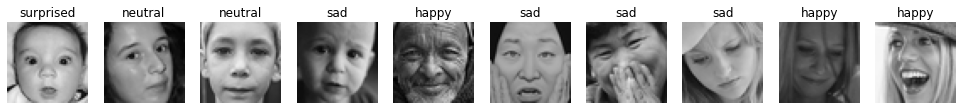

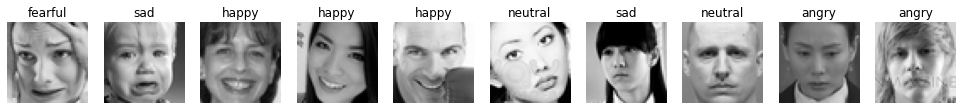

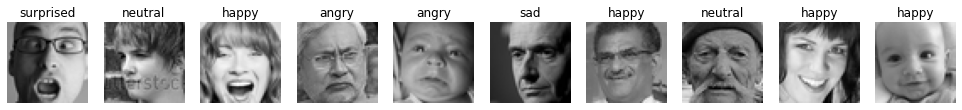

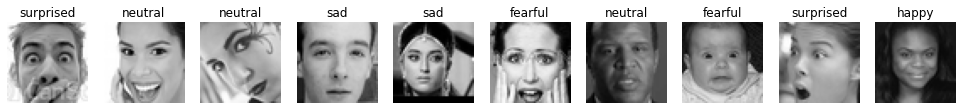

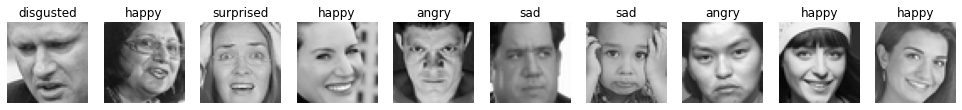

In [5]:
data_dir = TRAINDIR

test_transforms = transforms.Compose([transforms.ToTensor(),])

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels,classes

counter = 0
while counter < 5:
    to_pil = transforms.ToPILImage()
    images, labels, classes = get_random_images(10)
    fig=plt.figure(figsize=(17,17))
    for ii in range(len(images)):
        image = to_pil(images[ii])
        sub = fig.add_subplot(1, len(images), ii+1)
        res = int(labels[ii])
        sub.set_title(classes[res] )
        plt.axis('off')
        plt.imshow(image)
    plt.show()
    counter = counter + 1

# MODEL TRAIN

In [6]:
wandb.login()
wandb.init(project="w251-FinalProject")

wandb: Currently logged in as: pparkitny (use `wandb login --relogin` to force relogin)


In [7]:
#S3 Keys
ACCESS_KEY = 'X'
SECRET_KEY = 'X'

# Assume that this notebook only sees one GPU.
GPU=0

SEED=1
ARCH = 'resnet50'
#ARCH = 'resnet152'
#ARCH = 'resnet101'
#ARCH = 'tf_efficientnet_l2_ns'
EPOCHS = 100
START_EPOCH = 0
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
PRINT_FREQ = 10
TRAIN_BATCH= 1200
#TRAIN_BATCH= 100
VAL_BATCH=TRAIN_BATCH
WORKERS=4
TRAINDIR="../datasets/FER2013/train"
VALDIR="../datasets/FER2013/test"

In [8]:
random.seed(SEED)
torch.manual_seed(SEED)
cudnn.deterministic = False

In [9]:
wandb.init(config={"epochs": EPOCHS, "batch_size": TRAIN_BATCH, "momentum": MOMENTUM, "WEIGHT_DECAY": WEIGHT_DECAY, "arch": ARCH})

In [10]:
def upload_to_aws(local_file, bucket, s3_file):
    s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY,
                      aws_secret_access_key=SECRET_KEY)
    try:
        s3.upload_file(local_file, bucket, s3_file)
        print("Upload Successful")
        return True
    except FileNotFoundError:
        print("The file was not found")
        return False
    except NoCredentialsError:
        print("Credentials not available")
        return False

def download_from_aws(s3_file, bucket):
    s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY,
                      aws_secret_access_key=SECRET_KEY)
    try:
        s3.download_file(bucket, s3_file, s3_file)
        print("Download Successful")
        return True
    except FileNotFoundError:
        print("The file was not found")
        return False
    except NoCredentialsError:
        print("Credentials not available")
        return False

In [11]:
if not torch.cuda.is_available():
    print('GPU not detected.. did you pass through your GPU?')

In [12]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # Grad Scaler
    scaler = GradScaler()
    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if GPU is not None:
            images = images.cuda(GPU, non_blocking=True)
        if torch.cuda.is_available():
            target = target.cuda(GPU, non_blocking=True)

        # compute output
        with autocast():
          output = model(images)
          loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))
        
        # use the scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        wandb.log({"Loss/train": loss, 'acc1/train': top1.avg, 'acc5/train': top5.avg})

        if i % PRINT_FREQ == 0:
            progress.display(i)

In [13]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if GPU is not None:
                images = images.cuda(GPU, non_blocking=True)
            if torch.cuda.is_available():
                target = target.cuda(GPU, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINT_FREQ == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    wandb.log({"Loss/val": losses.avg, 'acc1/val': top1.avg, 'acc5/val': top5.avg})
    return top1.avg

In [14]:
def save_checkpoint(state, is_best, filename_in):
    torch.save(state, filename_in)
    if is_best:
        shutil.copyfile(filename_in, 'model_best.pth.tar')

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [16]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [17]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR * (0.1 ** (epoch // 40))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [18]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [19]:
NUM_CLASSES = 7

In [20]:
torch.cuda.set_device(GPU)
cudnn.benchmark = True

In [21]:
model = models.__dict__[ARCH](pretrained = True)
inf = model.fc.in_features
model.fc = nn.Linear(inf, NUM_CLASSES)

In [22]:
model.cuda(GPU)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
criterion = nn.CrossEntropyLoss().cuda(GPU)

In [24]:
optimizer = torch.optim.SGD(model.parameters(), LR,
                                momentum=MOMENTUM,
                                weight_decay=WEIGHT_DECAY)

In [25]:
if 1==2:
    saved_model_name = "Final_Project_Model_Epoch=9_acc1=tensor(62.1064, device='cuda:0')_resnet50_LR=XX.tar"
    download_from_aws(saved_model_name, 'w251-homework3')
    saved_model_name = "model_best.pth.tar"
    loc = 'cuda:{}'.format(GPU)
    checkpoint = torch.load(saved_model_name, map_location=loc)
    print(checkpoint['epoch'])
    print(checkpoint['best_acc1'])
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [26]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [27]:
transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 5))
    transforms.RandomPerspective(distortion_scale=0.8, p=1.0),
    transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.9, 0.99)),
    transforms.RandomEqualize(),
    transforms.RandomAutocontrast(),
    transforms.RandomSolarize(threshold=192.0),
    transforms.RandomPosterize(bits=2),
    transforms.RandomInvert(),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.repeat(3,1,1)),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [28]:
train_dataset = datasets.ImageFolder(
    TRAINDIR, transform=transform_train)

In [29]:
transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.repeat(3,1,1)),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [30]:
val_dataset = datasets.ImageFolder(
    VALDIR, transform=transform_val)

In [31]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=TRAIN_BATCH, shuffle=True,
        num_workers=WORKERS, pin_memory=True, sampler=None)

In [32]:
val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=VAL_BATCH, shuffle=True,
        num_workers=WORKERS, pin_memory=True, sampler=None) 

In [33]:
print(train_loader.dataset.classes)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [34]:
best_acc1 = 0

In [56]:
%%time
for epoch in range(START_EPOCH, EPOCHS):
    adjust_learning_rate(optimizer, epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    acc1 = validate(val_loader, model, criterion)

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)

    PATH = "M1_" +str(epoch) + "_acc1_" +str(acc1) + "_" + ARCH + ".tar" 
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': ARCH,
        'state_dict': model.state_dict(),
        'best_acc1': best_acc1,
        'optimizer' : optimizer.state_dict(),
    }, is_best,PATH)
    upload_to_aws(PATH, 'w251-homework3', PATH)
    time.sleep(1)
    
    scheduler.step()
    print('lr: ' + str(scheduler.get_last_lr()))

Epoch: [0][ 0/24]	Time  2.183 ( 2.183)	Data  1.819 ( 1.819)	Loss 5.0125e-01 (5.0125e-01)	Acc@1  82.75 ( 82.75)	Acc@5  99.50 ( 99.50)
Epoch: [0][10/24]	Time  0.329 ( 0.582)	Data  0.020 ( 0.276)	Loss 5.7372e-01 (5.2841e-01)	Acc@1  79.00 ( 80.69)	Acc@5  99.42 ( 99.59)
Epoch: [0][20/24]	Time  0.778 ( 0.533)	Data  0.482 ( 0.226)	Loss 7.3024e-01 (5.7681e-01)	Acc@1  74.83 ( 78.97)	Acc@5  99.58 ( 99.58)
Test: [0/6]	Time  1.110 ( 1.110)	Loss 1.5340e+00 (1.5340e+00)	Acc@1  56.58 ( 56.58)	Acc@5  97.92 ( 97.92)
 * Acc@1 57.746 Acc@5 98.203
Upload Successful
lr: [0.010002467198171341]
Epoch: [1][ 0/24]	Time  2.228 ( 2.228)	Data  1.835 ( 1.835)	Loss 6.8726e-01 (6.8726e-01)	Acc@1  74.08 ( 74.08)	Acc@5  99.75 ( 99.75)
Epoch: [1][10/24]	Time  0.306 ( 0.578)	Data  0.004 ( 0.268)	Loss 6.6011e-01 (6.6629e-01)	Acc@1  76.33 ( 75.45)	Acc@5  99.42 ( 99.47)
Epoch: [1][20/24]	Time  0.572 ( 0.517)	Data  0.270 ( 0.210)	Loss 6.6724e-01 (6.6671e-01)	Acc@1  76.25 ( 75.44)	Acc@5  99.58 ( 99.54)
Test: [0/6]	Time  1.12

# RESULTS

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
test_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor(),                                      
                                     ])

In [48]:
def predict_image(image):
    
    model.eval()
    with torch.no_grad():
    
        image_tensor = test_transforms(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        input = Variable(image_tensor)
        input = input.to(device)
        output = model(input)
        index = output.data.cpu().numpy().argmax()
       
    return index

In [49]:
def get_random_images(num):
    
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, classes

<Figure size 1080x1080 with 0 Axes>

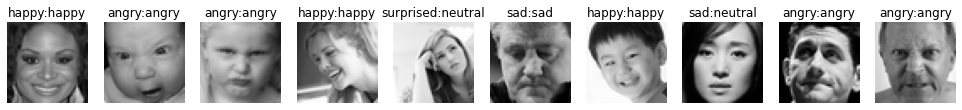

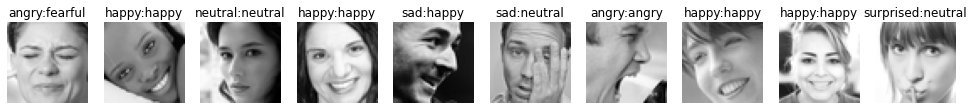

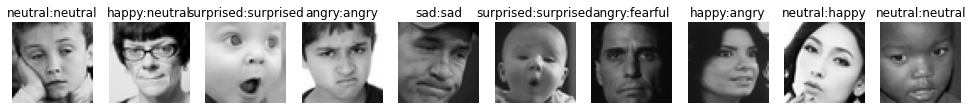

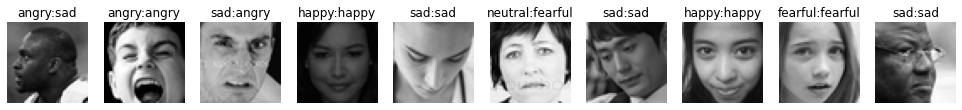

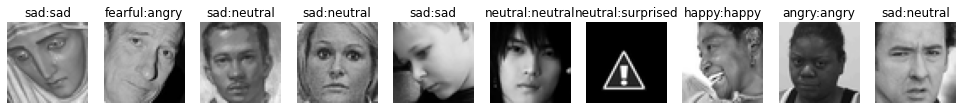

In [50]:
data_dir="../datasets/FER2013/test"
to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(15)
fig=plt.figure(figsize=(15,15))

counter = 0
while counter < 5:
    to_pil = transforms.ToPILImage()
    images, labels, classes = get_random_images(10)
    fig=plt.figure(figsize=(17,17))
    for ii in range(len(images)):
        image = to_pil(images[ii])
        index = predict_image(image)
        sub = fig.add_subplot(1, len(images), ii+1)
        res = int(labels[ii])
        label_class = int(labels[ii])
        sub.set_title(str(classes[index]) + ":" + classes[label_class])
        plt.axis('off')
        plt.imshow(image)
    plt.show()
    counter = counter + 1

## Confusion Matrix

In [51]:
actual = []
predicted = []

to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(3000)
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    res = int(labels[ii])
    label_class = int(labels[ii])
    actual.append(classes[label_class])
    predicted.append(str(classes[index]))

In [52]:
print(actual[20])
print(predicted[20])

happy
happy


In [53]:
cnf_matrix = confusion_matrix(actual, predicted)

In [54]:
#SOURCE https://runawayhorse001.github.io/LearningApacheSpark/classification.html
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig = plt.figure(figsize=(4, 4),frameon =False, dpi=200)  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[204   4  44  38  45  59   8]
 [ 13  28   1   2   2   5   0]
 [ 52   2 189  22  43  88  35]
 [ 15   0  11 612  41  39  12]
 [ 41   0  30  43 278 111  16]
 [ 68   2  53  35  77 270  12]
 [ 10   0  18  20  12   8 282]]


<Figure size 432x288 with 0 Axes>

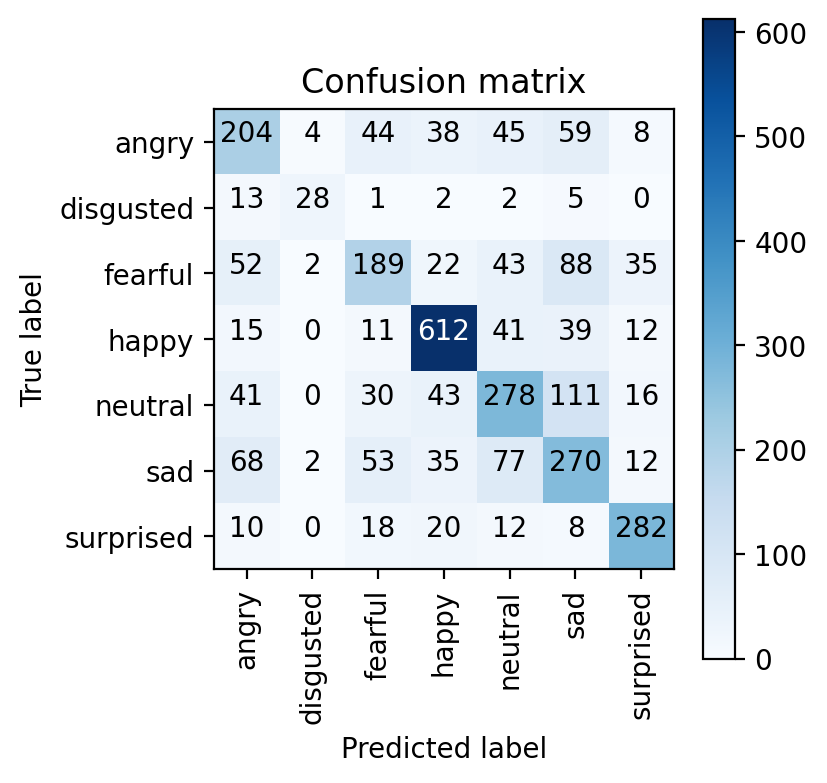

Normalized confusion matrix
[[0.50746269 0.00995025 0.10945274 0.09452736 0.1119403  0.14676617
  0.0199005 ]
 [0.25490196 0.54901961 0.01960784 0.03921569 0.03921569 0.09803922
  0.        ]
 [0.12064965 0.00464037 0.43851508 0.05104408 0.09976798 0.20417633
  0.0812065 ]
 [0.02054795 0.         0.01506849 0.83835616 0.05616438 0.05342466
  0.01643836]
 [0.07899807 0.         0.05780347 0.08285164 0.53564547 0.21387283
  0.03082852]
 [0.13152805 0.00386847 0.10251451 0.06769826 0.14893617 0.52224371
  0.02321083]
 [0.02857143 0.         0.05142857 0.05714286 0.03428571 0.02285714
  0.80571429]]


<Figure size 432x288 with 0 Axes>

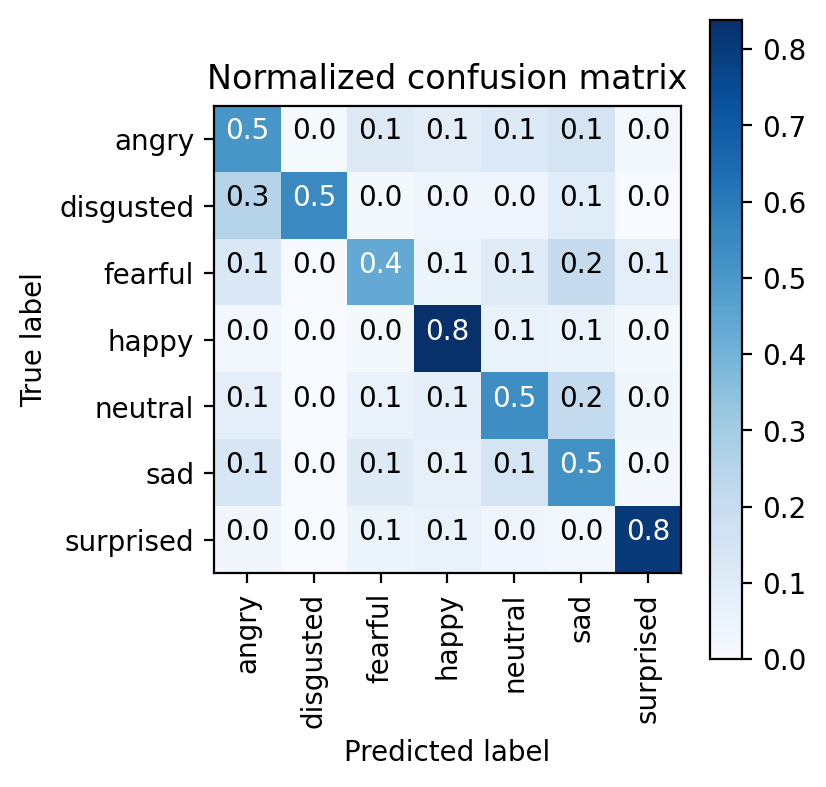

              precision    recall  f1-score   support

       angry       0.51      0.51      0.51       402
   disgusted       0.78      0.55      0.64        51
     fearful       0.55      0.44      0.49       431
       happy       0.79      0.84      0.81       730
     neutral       0.56      0.54      0.55       519
         sad       0.47      0.52      0.49       517
   surprised       0.77      0.81      0.79       350

    accuracy                           0.62      3000
   macro avg       0.63      0.60      0.61      3000
weighted avg       0.62      0.62      0.62      3000

0.621


In [55]:
# Plot non-normalized confusion matrix
plt.figure()
class_names = classes
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

print(classification_report(actual, predicted, target_names=class_names))

print(accuracy_score(actual, predicted))